In [1]:
# 'local[*]' - instructing to use all the cores (*) on a local machine
# 'appName' - will be given a random name unless specified, like Docker container image name
from pyspark.sql import SparkSession


spark = SparkSession.builder. \
        master('local[*]').\
        appName('credit risk').\
        getOrCreate()

In [2]:
# Data source CSV file must reside in the same folder
# The 'german.data-numeric' file delimits columns with 2 spaces ('  ')
#   Without data scrubbing, "IllegalArgumentException: 'Delimiter cannot be more than one character:   '"
df = spark.read.csv('german.data',sep=' ',inferSchema=False,header=False)

In [3]:
PRINT_ROW_NUM = 3
COL_TOTAL_NUM = len(df.columns)

print((df.count(),COL_TOTAL_NUM))
df.printSchema()
df.show(PRINT_ROW_NUM)

### SAMPLE OPERATION ###
# t = df.collect()[0]['features'] # Specify a partiuclar row-and-column intersection
# print(t[0], t.indices, , t.indices[18], t.indices.shape[0])

# col_names = []
# row_values = []

# for col_name in feature_columns:
#     col_names.append(col_name)

#     if get_dtype(df, col_name) == 'smallint':
#         row_values.append(df.collect()[0][col_name])
#     elif get_dtype(df, col_name) == 'vector' :
#         row_values.append(df.collect()[0][col_name][1])    
    
# print(tuple(col_names))
# print(tuple(row_values))

(1000, 21)
root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)

+---+---+---+---+----+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+
|_c0|_c1|_c2|_c3| _c4|_c5|_c6|_c7|_c8| _c9|_c10|_c11|_c12|_c13|_c14|_c15|_c16|_c17|_c18|_c19|_c20|
+---+---+---+---+----+---+---+---+---+-

All the columns with numbers are "**ordinal**" i.e., the magnitude in each column/feature means "something" (e.g., age, duration, credit amount and installment rate). Thus, **transformation** and **encoding** is NOT needed and they will be converted to non-string.

In [4]:
from pyspark.sql.types import ShortType # a signed 16-bit integer vs. IntegerType (a signed 32-bit integer)

col_indices_of_ordinal_numbers = [2, 5, 8, 11, 13, 16, 18] # Ignore the target/label column i.e., '_c20', the last column
col_indices_of_categorical_numbers = []

def convert_integer_to_string_in_list(aList: list) -> list:
    return [str(item) for item in aList]

for col_idx in range(1, COL_TOTAL_NUM):
    if col_idx not in col_indices_of_ordinal_numbers:
        col_indices_of_categorical_numbers.append(col_idx)

for col_name in df.schema.names:
    # change the name of each column e.g., "_c0" -> "1"
    new_col_num = int(col_name.replace('_c', '')) + 1
    df = df.withColumnRenamed(col_name, str(new_col_num))
    
    if new_col_num in col_indices_of_ordinal_numbers:  
        df = df.withColumn(str(new_col_num), df[str(new_col_num)].cast(ShortType()))
        
col_indices_of_ordinal_numbers = convert_integer_to_string_in_list(col_indices_of_ordinal_numbers)
col_indices_of_categorical_numbers = convert_integer_to_string_in_list(col_indices_of_categorical_numbers)

In [5]:
df.show(PRINT_ROW_NUM)
df.dtypes

+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+
|  1|  2|  3|  4|   5|  6|  7|  8|  9|  10| 11|  12| 13|  14|  15| 16|  17| 18|  19|  20| 21|
+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+
|A11|  6|A34|A43|1169|A65|A75|  4|A93|A101|  4|A121| 67|A143|A152|  2|A173|  1|A192|A201|  1|
|A12| 48|A32|A43|5951|A61|A73|  2|A92|A101|  2|A121| 22|A143|A152|  1|A173|  1|A191|A201|  2|
|A14| 12|A34|A46|2096|A61|A74|  2|A93|A101|  3|A121| 49|A143|A152|  1|A172|  2|A191|A201|  1|
+---+---+---+---+----+---+---+---+---+----+---+----+---+----+----+---+----+---+----+----+---+
only showing top 3 rows



[('1', 'string'),
 ('2', 'smallint'),
 ('3', 'string'),
 ('4', 'string'),
 ('5', 'smallint'),
 ('6', 'string'),
 ('7', 'string'),
 ('8', 'smallint'),
 ('9', 'string'),
 ('10', 'string'),
 ('11', 'smallint'),
 ('12', 'string'),
 ('13', 'smallint'),
 ('14', 'string'),
 ('15', 'string'),
 ('16', 'smallint'),
 ('17', 'string'),
 ('18', 'smallint'),
 ('19', 'string'),
 ('20', 'string'),
 ('21', 'string')]

**Databricks**, the leading crowd platform for massive scale data engineering and collaborative data science with optimized Apache Spark™ clusters on AWS or Azure, just pubslihed articles [here](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/5703650563260092/2738738457173388/3024994340111770/latest.html) and [there](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/7274796508260238/2844662950865680/2879908466733289/latest.html) on Apache Spark MLlib Pipelines API. Let's try that.

In [6]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoderEstimator
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler


COL_SUFFIX_IDX = "_INDEX"
COL_SUFFIX_VEC = "_VEC"

stages = []

for col_idx in col_indices_of_categorical_numbers:
    # Category Indexing with StringIndexer
    stringIndexer = StringIndexer(inputCol=col_idx, outputCol=col_idx + COL_SUFFIX_IDX)
    
    # Use OneHotEncoder to convert categorical variables into binary SparseVectors
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col_idx + COL_SUFFIX_VEC])
    
    # Add stages. These are not run here, but will run all at once later on
    stages += [stringIndexer, encoder]

In [7]:
# The two columns MUST be marked as 'label' and 'features'!
# Otherwise, "Py4JJavaError: An error occurred while calling o1175.fit. : java.lang.IllegalArgumentException: Field "label" does not exist."
LABEL_COL_NAME = "label"
FEATURE_VECTOR_COL_NAME = "features"

label_stringIdx = StringIndexer(inputCol=str(COL_TOTAL_NUM), outputCol=LABEL_COL_NAME)
stages += [label_stringIdx]

In [8]:
# Transform all features into a vector using VectorAssembler
assemblerInputs = [col_idx + COL_SUFFIX_IDX for col_idx in col_indices_of_categorical_numbers] + col_indices_of_ordinal_numbers
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol=FEATURE_VECTOR_COL_NAME)
stages += [assembler]

In [9]:
from pyspark.ml.feature import StandardScaler


STANDARDIZED_FEATURES_COL_NAME = 'std_features'

standardScaler = StandardScaler(withMean=True, withStd=True, inputCol=FEATURE_VECTOR_COL_NAME, outputCol=STANDARDIZED_FEATURES_COL_NAME)
stages += [standardScaler]

In [10]:
partialPipeline = Pipeline().setStages(stages)
pipelineModel = partialPipeline.fit(df)
df_pipeline = pipelineModel.transform(df)

In [11]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics


def print_performance_metrics(predictions):
  # Evaluate model
  evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
  auc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
  aupr = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})
  print("auc = {}".format(auc))
  print("aupr = {}".format(aupr))

  # get rdd of predictions and labels for mllib eval metrics
  predictionAndLabels = predictions.select("prediction","label").rdd

  # Instantiate metrics objects
  binary_metrics = BinaryClassificationMetrics(predictionAndLabels)
  multi_metrics = MulticlassMetrics(predictionAndLabels)

  # Area under precision-recall curve
  print("Area under PR = {}".format(binary_metrics.areaUnderPR))
  # Area under ROC curve
  print("Area under ROC = {}".format(binary_metrics.areaUnderROC))
  # Accuracy
  print("Accuracy = {}".format(multi_metrics.accuracy))
  # Confusion Matrix
  print(multi_metrics.confusionMatrix())
  
  # F1
  print("F1 = {}".format(multi_metrics.fMeasure()))
  # Precision
  print("Precision = {}".format(multi_metrics.precision()))
  # Recall
  print("Recall = {}".format(multi_metrics.recall()))
  # FPR
  print("FPR = {}".format(multi_metrics.falsePositiveRate(0.0)))
  # TPR
  print("TPR = {}".format(multi_metrics.truePositiveRate(0.0)))

In [12]:
import numpy as np
from pyspark.ml.feature import PCA
from pyspark.ml.classification import LogisticRegression


PCA_FEATURES_COL_NAME = "pca_features"
MAX_ITER_NUM = 50

PCA_feature_num_list = np.arange(1, COL_TOTAL_NUM, 1)
PCA_explainedVariances_list = []

for PCA_feature_num in PCA_feature_num_list:
    PCA_extracted = PCA(k=PCA_feature_num, inputCol=STANDARDIZED_FEATURES_COL_NAME, outputCol=PCA_FEATURES_COL_NAME)

    pca_model = PCA_extracted.fit(df_pipeline)
    df_PCA = pca_model.transform(df_pipeline)

    df_train, df_test = df_PCA.randomSplit([0.7, 0.3], seed = 100)
    
    LR = LogisticRegression(labelCol=LABEL_COL_NAME, featuresCol=PCA_FEATURES_COL_NAME, maxIter=MAX_ITER_NUM)
    LR_model = LR.fit(df_train)
    LR_preds = LR_model.transform(df_test) # Scikit-Learn uses predict() method for prediction

#     print(pca_model.explainedVariance) [0.11832168009876139,0.08249816430977125,0.07512312765618046]
#     print(np.cumsum(pca_model.explainedVariance)) [0.11832168 0.20081984 0.27594297]

    cumulative_explained_variance = np.cumsum(pca_model.explainedVariance)[PCA_feature_num - 1]

    PCA_explainedVariances_list.append(cumulative_explained_variance)
    print(str(PCA_feature_num) + ": " + str(cumulative_explained_variance))

#     LR_preds.select(LABEL_COL_NAME, "prediction", "rawPrediction", "probability").show(PRINT_ROW_NUM)
#     print_performance_metrics(LR_preds)

1: 0.11832168009876139
2: 0.20081984440853262
3: 0.2759429720647131
4: 0.3434691583369005
5: 0.4068048276404337
6: 0.4646192825677727
7: 0.5212579515868058
8: 0.5726833221543236
9: 0.620595299353551
10: 0.66634309561251
11: 0.71070821099644
12: 0.7534198111210798
13: 0.7946167029948367
14: 0.8334120028543393
15: 0.8697509575845473
16: 0.9040447458263459
17: 0.936440526700285
18: 0.9657619466572893
19: 0.9871407977706779
20: 1.0000000000000002


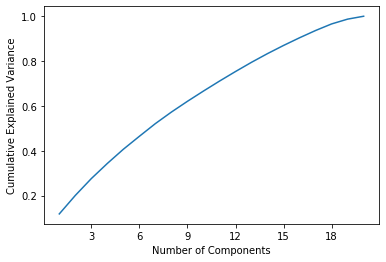

In [13]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


ax = plt.figure().gca()
ax.plot(PCA_feature_num_list, PCA_explainedVariances_list)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance');

It's pretty apparent that ALL the features should be used in making prediction, as each component noteciably adds variance in relation to the total variance - almost in a straight-line fashion.


## Model Comparison##

In [14]:
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import LinearSVC
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import NaiveBayes


PARAMETER_CHOICE_NUM = 1 # Just for practice
classification_model_list = []

LR = LogisticRegression(labelCol=LABEL_COL_NAME, featuresCol=STANDARDIZED_FEATURES_COL_NAME)
LR_paramGrid = (ParamGridBuilder()
             .addGrid(LR.regParam, np.linspace(0.01, 2, PARAMETER_CHOICE_NUM))
             .addGrid(LR.elasticNetParam, np.linspace(0, 1, PARAMETER_CHOICE_NUM))
             .addGrid(LR.maxIter, np.linspace(1, MAX_ITER_NUM, PARAMETER_CHOICE_NUM, dtype = int))
             .build())
classification_model_list.append([LR, LR_paramGrid])


RF = RandomForestClassifier(labelCol=LABEL_COL_NAME, featuresCol=STANDARDIZED_FEATURES_COL_NAME)
RF_ParamGrid = (ParamGridBuilder()
             .addGrid(RF.numTrees, np.linspace(1, MAX_ITER_NUM, PARAMETER_CHOICE_NUM, dtype = int))
             .addGrid(RF.maxDepth, np.linspace(1, COL_TOTAL_NUM, PARAMETER_CHOICE_NUM))
             .build())
classification_model_list.append([RF, RF_ParamGrid])


GB = GBTClassifier(labelCol=LABEL_COL_NAME, featuresCol=STANDARDIZED_FEATURES_COL_NAME)
GB_ParamGrid = (ParamGridBuilder()
             .addGrid(GB.maxIter, np.linspace(1, MAX_ITER_NUM, PARAMETER_CHOICE_NUM, dtype = int))
             .addGrid(GB.maxDepth, np.linspace(1, COL_TOTAL_NUM, PARAMETER_CHOICE_NUM))
             .build())
classification_model_list.append([GB, GB_ParamGrid])


LSVC = LinearSVC(maxIter=MAX_ITER_NUM)
LSVC_paramGrid = (ParamGridBuilder()
             .addGrid(LSVC.regParam, np.linspace(0.01, 2, PARAMETER_CHOICE_NUM))
             .addGrid(LSVC.maxIter, np.linspace(1, MAX_ITER_NUM, PARAMETER_CHOICE_NUM, dtype = int))
             .build())
classification_model_list.append([LSVC, LSVC_paramGrid])


# OVR = OneVsRest(classifier=LR)
# OVR_paramGrid = (ParamGridBuilder().build())
# classification_model_and_paramgrid_list.append([OVR, OVR_paramGrid])
# IllegalArgumentException: 'Field "rawPrediction" does not exist.\nAvailable fields: 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 1_INDEX, 1_VEC, 3_INDEX, 3_VEC, 4_INDEX, 4_VEC, 6_INDEX, 6_VEC, 7_INDEX, 7_VEC, 9_INDEX, 9_VEC, 10_INDEX, 10_VEC, 12_INDEX, 12_VEC, 14_INDEX, 14_VEC, 15_INDEX, 15_VEC, 17_INDEX, 17_VEC, 19_INDEX, 19_VEC, 20_INDEX, 20_VEC, label, features, std_features, pca_features, CrossValidator_01aa8f348031_rand, prediction'    

NB = NaiveBayes()
NB_paramGrid = (ParamGridBuilder()
             .addGrid(NB.smoothing, np.linspace(0, 1, PARAMETER_CHOICE_NUM))
             .build())
classification_model_list.append([NB, NB_paramGrid])

[Wei-Ming Lee](https://www.wiley.com/en-ca/Python+Machine+Learning-p-9781119545637) states, "The purpose of cross-validation is not for training your model, but rather it is for model checking. Cross-validation (CV) is useful when you need to compare different machine learning algorithms to see how they perform with the given dataset."

As per above, a sample, canonical set of parameters of each model, cited in Spark doc, are to be tested in much fewer permutations via `ParamGrid` as part of CV, in order to determine the best `areaUnderROC` of each model.

Although `ParamGrid` is tantamount to scikit-learn's [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html), it is strictly speaking used for hypermarameter tuning.

In [15]:
from pyspark.ml.tuning import CrossValidator


evaluator = BinaryClassificationEvaluator()

for classification_model in classification_model_list:
    cv = CrossValidator(estimator=classification_model[0], 
                        estimatorParamMaps=classification_model[1],
                        evaluator=evaluator,
                        numFolds=5)

    cvModel = cv.fit(df_train)
    predictions = cvModel.transform(df_test)
    
    model_details_in_list = classification_model_list[classification_model_list.index(classification_model)]
    model_details_in_list.append(evaluator.evaluate(predictions)) # By default, areaUnderROC
    model_details_in_list.append(cvModel.bestModel)
#     print(evaluator.evaluate(predictions))

In [16]:
# classification_model_and_paramgrid_list[x][0] = an instannce of classification model
# classification_model_and_paramgrid_list[x][1] = ParamGrid list
# classification_model_and_paramgrid_list[x][2] = The default 'areaUnderROC' value of the best model of the classification model according to CV
# classification_model_and_paramgrid_list[x][3] = The best model

# Sort by 'areaUnderROC' value of each classification model
classification_model_list.sort(key=lambda model: model[2], reverse=True)

for classification_model in classification_model_list:
    model_name = str(classification_model[0]) # classification_model[0] is the best model, when sorted
    print(model_name[:model_name.find("_")] + ": " + str(classification_model[2]))

LogisticRegression: 0.7211899489746785
GBTClassifier: 0.681188023490902
RandomForestClassifier: 0.5
LinearSVC: 0.4781457591219794
NaiveBayes: 0.40627707711562505


In [17]:
from itertools import chain


best_model = classification_model_list[0][3]

final_model = best_model.transform(df_pipeline)
attrs = sorted((attr["idx"], attr["name"]) for attr in (chain(*final_model
        .schema['features'].metadata["ml_attr"]["attrs"].values())))

sorted([(name, best_model.coefficients[idx]) for idx, name in attrs], key=lambda coefficient: coefficient[1], reverse=True)

[('2', 0.4425948084598169),
 ('1_INDEX', 0.39618089494649256),
 ('5', 0.2921000749056233),
 ('15_INDEX', 0.27947773614577814),
 ('12_INDEX', 0.2298915437703011),
 ('3_INDEX', 0.22041131780203232),
 ('14_INDEX', 0.19825481712899),
 ('4_INDEX', 0.1947921605633574),
 ('9_INDEX', 0.1782953512786073),
 ('8', 0.1680830998972306),
 ('7_INDEX', 0.1644038874121714),
 ('10_INDEX', 0.12518506615774153),
 ('17_INDEX', 0.031353772949419816),
 ('11', 0.014629371319035049),
 ('18', -0.026711081145265846),
 ('16', -0.06291397012281359),
 ('19_INDEX', -0.12799455889359893),
 ('13', -0.1768630476426147),
 ('20_INDEX', -0.17989922498426686),
 ('6_INDEX', -0.304823570093416)]

In [18]:
model_path = "./model"
classification_model_list[0][3].save(model_path)

# model_loaded = RandomForestClassificationModel.load(model_path)

# Addendum #

## **`dropLast=False`** in OneHotEncoder() ##

Let's take a close look at this parameter.

As per Spark [doc](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.OneHotEncoder):

"A one-hot encoder that maps a column of category indices to a column of binary vectors, with at most a single one-value per row that indicates the input category index. For example with 5 categories, an input value of 2.0 would map to an output vector of [0.0, 0.0, 1.0, 0.0]. The last category is not included by default (configurable via dropLast) because it makes the vector entries sum up to one, and hence linearly dependent. So an input value of 4.0 maps to [0.0, 0.0, 0.0, 0.0]."

Linearly dependent? What does that mean? Red Huq has written a superb article on [this](https://inmachineswetrust.com/posts/drop-first-columns/).

Comparing the two features column with or without `dropLast=False` via `df_final.collect()[0]['features']`:

{with}  
`SparseVector(61, {0: 6.0, 1: 1169.0, 2: 4.0, 3: 4.0, 4: 67.0, 5: 2.0, 6: 1.0, 8: 1.0, 12: 1.0, 16: 1.0, 27: 1.0, 32: 1.0, 36: 1.0, 40: 1.0, 44: 1.0, 47: 1.0, 50: 1.0, 53: 1.0, 58: 1.0, 59: 1.0})`

{without}  
`SparseVector(48, {0: 6.0, 1: 1169.0, 2: 4.0, 3: 4.0, 4: 67.0, 5: 2.0, 6: 1.0, 8: 1.0, 11: 1.0, 14: 1.0, 24: 1.0, 28: 1.0, 31: 1.0, 34: 1.0, 37: 1.0, 39: 1.0, 41: 1.0, 43: 1.0, 47: 1.0})`

The difference between 61 and 48? 13! This represent 13 times one (1), an extra category from each column of the 13 that was one-hot-encoded, represented with the prefix "_VEC".

Why does the {with} scenario has an element of **`12: 1.0`**, while the {without} does **`11: 1.0`**? Simply put, the first seven (7) elements i.e., from `0:` to `6:`, are identical because we pick up all the `smallint` datatypes first, no one-hot-encoded columns yet.

The difference starts from that point onwards, when we take in the columns with the suffix of "_VEC".

As for the "1_VEC", although both scenarios has one (1) flag in the second one-hot-encoded value column in the `8:`, the {with} scenario occupies between `7:` and `10:` whereas the {without} does between `7:` and `9:`, judging from `1_VEC=SparseVector(4, {1: 1.0})` vs. `1_VEC=SparseVector(3, {1: 1.0})`.

(If the value is the first one-hot-encoded value, it will be `7: 1.0` and `1_VEC=SparseVector(4, {**0**: 1.0})` ({with}) and `1_VEC=SparseVector(3, {**0**: 1.0})` ({without}).)

Next, the "3_VEC" one-hot-encoded columns occupy between `11:` and `15:` {with} and between `10:` and `13:` {without} respectively. Given `3_VEC=SparseVector(5, {1: 1.0})` vs. `3_VEC=SparseVector(4, {1: 1.0})`, the second one-hot-encoded value includes a value of 1, so **`12: 1.0`** ({with}) and **`11: 1.0`** ({without}).

Comparing the columns with or without `dropLast=False` via `df.collect()[0]`:

{with}  
1='A11', 2=6, 3='A34', 4='A43', 5=1169, 6='A65', 7='A75', 8=4, 9='A93', 10='A101', 11=4, 12='A121', 13=67, 14='A143', 15='A152', 16=2, 17='A173', 18=1, 19='A192', 20='A201', target=1, 1_INDEX=1.0, 1_VEC=SparseVector(4, {1: 1.0}), 3_INDEX=1.0, 3_VEC=SparseVector(5, {1: 1.0}), 4_INDEX=0.0, 4_VEC=SparseVector(10, {0: 1.0}), 6_INDEX=1.0, 6_VEC=SparseVector(5, {1: 1.0}), 7_INDEX=1.0, 7_VEC=SparseVector(5, {1: 1.0}), 9_INDEX=0.0, 9_VEC=SparseVector(4, {0: 1.0}), 10_INDEX=0.0, 10_VEC=SparseVector(3, {0: 1.0}), 12_INDEX=1.0, 12_VEC=SparseVector(4, {1: 1.0}), 14_INDEX=0.0, 14_VEC=SparseVector(3, {0: 1.0}), 15_INDEX=0.0, 15_VEC=SparseVector(3, {0: 1.0}), 17_INDEX=0.0, 17_VEC=SparseVector(4, {0: 1.0}), 19_INDEX=1.0, **19_VEC=SparseVector(2, {1: 1.0})**, 20_INDEX=0.0, 20_VEC=SparseVector(2, {0: 1.0})

{without}  
1='A11', 2=6, 3='A34', 4='A43', 5=1169, 6='A65', 7='A75', 8=4, 9='A93', 10='A101', 11=4, 12='A121', 13=67, 14='A143', 15='A152', 16=2, 17='A173', 18=1, 19='A192', 20='A201', target=1, 1_INDEX=1.0, 1_VEC=SparseVector(3, {1: 1.0}), 3_INDEX=1.0, 3_VEC=SparseVector(4, {1: 1.0}), 4_INDEX=0.0, 4_VEC=SparseVector(9, {0: 1.0}), 6_INDEX=1.0, 6_VEC=SparseVector(4, {1: 1.0}), 7_INDEX=1.0, 7_VEC=SparseVector(4, {1: 1.0}), 9_INDEX=0.0, 9_VEC=SparseVector(3, {0: 1.0}), 10_INDEX=0.0, 10_VEC=SparseVector(2, {0: 1.0}), 12_INDEX=1.0, 12_VEC=SparseVector(3, {1: 1.0}), 14_INDEX=0.0, 14_VEC=SparseVector(2, {0: 1.0}), 15_INDEX=0.0, 15_VEC=SparseVector(2, {0: 1.0}), 17_INDEX=0.0, 17_VEC=SparseVector(3, {0: 1.0}), 19_INDEX=1.0, **19_VEC=SparseVector(1, {})**, 20_INDEX=0.0, 20_VEC=SparseVector(1, {0: 1.0})

Take a note of the difference between the two 19_VEC columns with bianary outcomes.

Also, check out Renjith Madhavan's [Sparse Vector vs. Dense Vector](https://youtu.be/oGwEv82ifrE).

## PCA vs. SVD ##

Andre Perunicic goes over SVD on his succinct [article](https://intoli.com/blog/pca-and-svd/).

For someone like me who is penchant for LOTS of visuals, Cory Maklin has done [it](https://towardsdatascience.com/singular-value-decomposition-example-in-python-dab2507d85a0) - with numPy. 

[Nick walsh](https://stackoverflow.com/a/56012609) also attests that "SVD is the more stable solution for preserving data integrity due to rounding inaccuracies as a result of computing the product of your dataset by its tranpose matrix (X*X⊤)" as well as J.M.'s [Läuchli matrix example](https://math.stackexchange.com/a/359428) and Amoeba's [Eigenvalue Decomposition comparison](https://stats.stackexchange.com/a/87536).

Bear in mind that SVD runs much SLOWER as it is computationally more INTENSIVE.

Also, take note of Vaquar Khan's [mllib vs. ml](https://stackoverflow.com/a/58799652) and Mohamed Ali Jamaoui's [pySpark vs. Scipy](https://stackoverflow.com/a/58799652) comparions.

In reference to [Elias Abou Haydar and Sergul Aydore's discussion](https://stackoverflow.com/a/38107324), let's import their SVD method as Java wrapper.

In [19]:
from pyspark.mllib.common import callMLlibFunc, JavaModelWrapper
from pyspark.mllib.linalg.distributed import RowMatrix


class SVD(JavaModelWrapper):
    """Wrapper around the SVD scala case class"""
    @property
    def U(self):
        """ Returns a RowMatrix whose columns are the left singular vectors of the SVD if computeU was set to be True."""
        u = self.call("U")
        if u is not None:
            return RowMatrix(u)

    @property
    def s(self):
        """Returns a DenseVector with singular values in descending order."""
        return self.call("s")

    @property
    def V(self):
        """ Returns a DenseMatrix whose columns are the right singular vectors of the SVD."""
        return self.call("V")
    
def computeSVD(row_matrix, k, computeU=False, rCond=1e-9):
    """
    Computes the singular value decomposition of the RowMatrix.
    The given row matrix A of dimension (m X n) is decomposed into U * s * V'T where
    * s: DenseVector consisting of square root of the eigenvalues (singular values) in descending order.
    * U: (m X k) (left singular vectors) is a RowMatrix whose columns are the eigenvectors of (A X A')
    * v: (n X k) (right singular vectors) is a Matrix whose columns are the eigenvectors of (A' X A)
    :param k: number of singular values to keep. We might return less than k if there are numerically zero singular values.
    :param computeU: Whether of not to compute U. If set to be True, then U is computed by A * V * sigma^-1
    :param rCond: the reciprocal condition number. All singular values smaller than rCond * sigma(0) are treated as zero, where sigma(0) is the largest singular value.
    :returns: SVD object
    """
    java_model = row_matrix._java_matrix_wrapper.call("computeSVD", int(k), computeU, float(rCond))
    return SVD(java_model)

### Work in Progress - Obtain SVD ###

In [22]:
#from pyspark.mllib.linalg import Vectors
#from pyspark.sql import sqlContext
#from pyspark.mllib.utils import MLUtils
#from pyspark.mllib.util import MLUtils


RAW_FEATURES = "raw_feasures"
PCA_FEATURES = "pca_features"
PCA_FEATURES_NUM = 10

pca_extracted = PCA(k=PCA_FEATURES_NUM, inputCol=RAW_FEATURES, outputCol=PCA_FEATURES)
# type(pca_extracted) # pyspark.ml.feature.PCA

model = pca_extracted.fit(df_pca)
# type(model) # pyspark.ml.feature.PCAModel

features = model.transform(df_pca) # this create a DataFrame with the regular features and pca_features
# type(features) # pyspark.sql.dataframe.DataFrame
features.collect()[0][PCA_FEATURES]

# # We can now extract the pca_features to prepare our RowMatrix.
pca_features = features.select(PCA_FEATURES).rdd.map(lambda row : row[0])
# type(pca_features) # pyspark.rdd.PipelinedRDD


# mat = RowMatrix(pca_features)
# type(mat) # pyspark.mllib.linalg.distributed.RowMatrix

#svd_model = RowMatrix(pca_features).computeSVD(PCA_FEATURES_NUM, True)
#svd_model = mat.computeSVD(PCA_FEATURES_NUM, True)

<class 'pyspark.ml.feature.PCA'>


In [42]:
# TypeError: Cannot convert type <class 'pyspark.ml.linalg.DenseVector'> into Vector
#svd = computeSVD(mat,PCA_FEATURES_NUM,True)
#svd = mat.computeSVD(PCA_FEATURES_NUM,True)

# from pyspark.mllib.utils import MLUtils
from pyspark.mllib.util import MLUtils
# df_pca = MLUtils.convertVectorColumnsFromML(df_pca, RAW_FEATURES)
#df_pca = MLUtils.convertVectorColumnsToML(df_pca, RAW_FEATURES)
# df_pca.collect()[0][RAW_FEATURES]
# type(df_pca.collect()[0][RAW_FEATURES])

pca_features = MLUtils.convertVectorColumnsToML(pca_features, PCA_FEATURES)
type(pca_features.collect()[0][PCA_FEATURES])

TypeError: Input dataset must be a DataFrame but got <class 'pyspark.rdd.PipelinedRDD'>.